In [1]:
import numpy as np
import scipy.stats as scs
from tqdm import tqdm

In [2]:

def dist_M(m, mu1, mu2, y):
    m = int(m)
    dist_M_log = -(1/2) * (np.sum((y[:m] - np.tile(mu1, m))**2) +
                           np.sum((y[m:] - np.tile(mu2, len(y)-m))**2))
    return dist_M_log

def cdist_M(mu1, mu2, y):
    nprop_log_like = [dist_M(k, mu1, mu2, y) for k in np.arange(1, len(y))]
    out = np.exp(nprop_log_like) / np.sum(np.exp(nprop_log_like))
    return out

def gibbs2(data,t):
    mu1s = [1] + np.zeros(t)
    mu2s = [0] + np.zeros(t)
    Ms = [1] + np.zeros(t)
    N = len(data)

    for i in tqdm(range(1,t)):
        #print(i,'-----------------')
        mu1s[i] = scs.norm( 100/((100)*Ms[i-1]+1) + np.mean(data[:int(Ms[i-1])]),100/((100)*Ms[i-1]+1)).rvs(1)
        #print(mu1s[i])
        mu2s[i] = scs.norm( 100/((100)*(N-Ms[i-1])+1) + np.mean(data[int(Ms[i-1]):]),100/((100)*(N-Ms[i-1])+1)).rvs(1)
        #print(mu2s[i])
        if np.random.uniform() < 0.9:
            Ms[i] = np.random.choice(np.arange(1,len(data)),p=cdist_M(mu1s[i],mu2s[i],data))
        else:
            Ms[i] = np.random.choice(np.arange(1,len(data)),p=cdist_M(mu1s[i],mu1s[i],data))
        #print(Ms[i])
    return np.array([mu1s,mu2s,Ms])

100%|██████████| 999/999 [00:01<00:00, 622.14it/s]


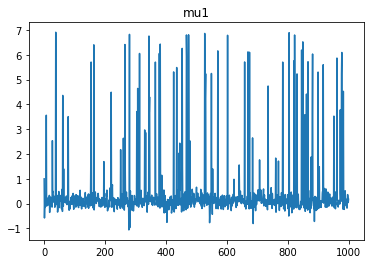

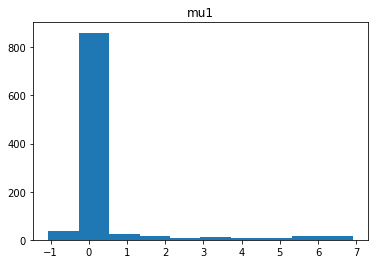

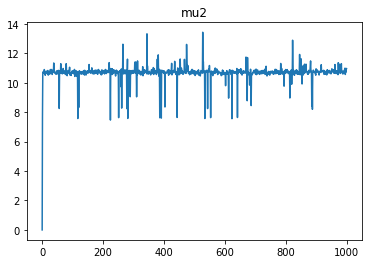

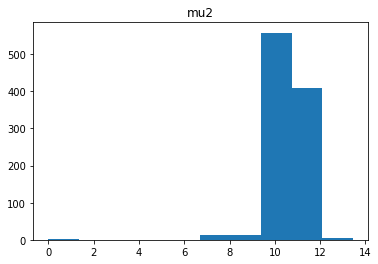

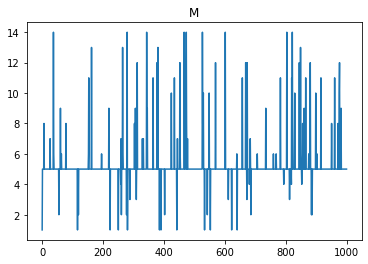

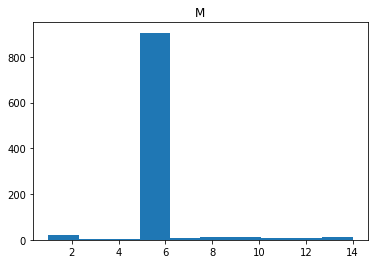

In [33]:
from matplotlib import pyplot as plt
test = gibbs2(np.append((np.random.normal(0,1,5)),(np.random.normal(10,1,10))),1000)
plt.plot(test[0])
plt.title('mu1')
plt.show()
plt.hist(test[0])
plt.title('mu1')
plt.show()
plt.plot(test[1])
plt.title('mu2')
plt.show()
plt.hist(test[1])
plt.title('mu2')
plt.show()
plt.plot(test[2])
plt.title('M')
plt.show()
plt.title('M')
plt.hist(test[2])
plt.show()

In [78]:
# ABC style
from tqdm import tqdm
from scipy.spatial.distance import pdist

def prior_mu(x):
    return scs.norm(0,10).rvs(1)
def prior_M(len_):
    return np.random.choice(np.arange(1,len_-1),size=1)

def Energy_Score(beta,observations_y,simulations_Y):

    n = len(observations_y)
    m = len(simulations_Y)
    observations_y = np.array(observations_y)
    simulations_Y = np.array(simulations_Y)

    # First part |Y-y|. Gives the L2 dist scaled by power beta. Is a vector of length n/one value per location.
    diff_Y_y = np.power(
            np.linalg.norm(
                np.tile(observations_y,(m,1)) -
                simulations_Y,
            axis=1),
        beta)

    #Second part |Y-Y'|. 2* because pdist counts only once.
    diff_Y_Y = 2 * np.power(
        pdist(simulations_Y)
    ,beta)

    Energy = 2 * np.mean(diff_Y_y) - np.sum(diff_Y_Y)/(m*(m-1))
    return Energy

def abc(data,t,method='nll',beta=0.5):
    mu1s = []
    mu2s = []
    Ms =  []
    stat = []
    for i in tqdm(range(1,t)):
        M_prop = int(prior_M(len(data)))
        mu1_prop = prior_mu(1)
        mu2_prop = prior_mu(1)
        
        if method == 'SR':
            sims = np.array([np.concatenate((scs.norm(mu1_prop,scale=1).rvs(M_prop),scs.norm(mu2_prop,scale=1).rvs(len(data)-M_prop))) for i in range(10)])
        else:
            sims = np.concatenate((scs.norm(mu1_prop,scale=1).rvs(M_prop),scs.norm(mu2_prop,scale=1).rvs(len(data)-M_prop)))
        mu1s.append(mu1_prop)
        mu2s.append(mu2_prop)
        Ms.append(M_prop)
        if method == 'nll':
            stat.append(scs.norm(mu1_prop,scale=1).logpdf(data[:M_prop]).sum()+scs.norm(mu2_prop,scale=1).logpdf(data[M_prop:]).sum())
        if method == 'L2':
            stat.append(-np.linalg.norm(np.mean(sims[:M_prop])-np.mean(data[:M_prop]))-np.linalg.norm(np.mean(sims[M_prop:])-np.mean(data[M_prop:])))
        if method == 'SR':
            stat.append(Energy_Score(beta,data,sims))
    return np.array([mu1s,mu2s,Ms,stat])


### NLL

100%|██████████| 9999/9999 [00:30<00:00, 328.52it/s]
C:\Users\david\AppData\Local\Temp\ipykernel_142232\2507483909.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([mu1s,mu2s,Ms,stat])


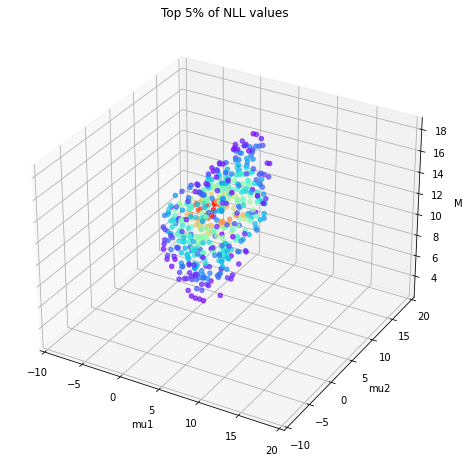

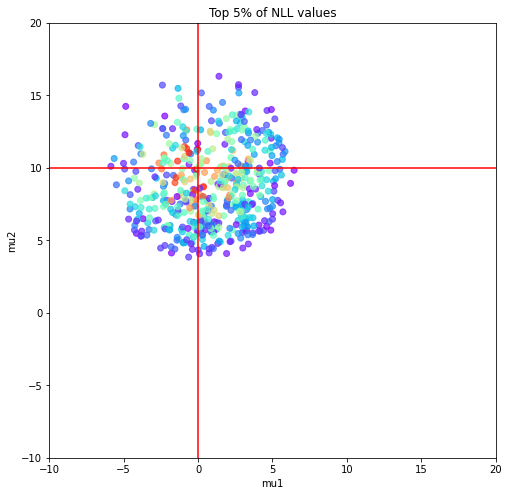

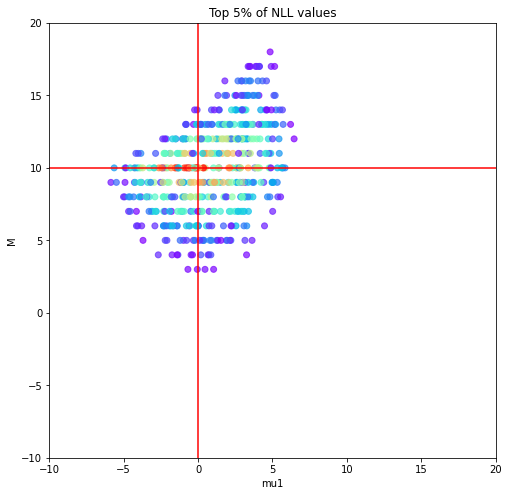

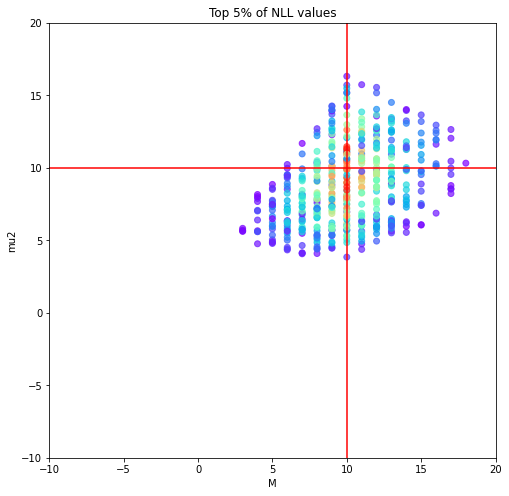

In [77]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Generate some test data
test = abc(np.append((np.random.normal(0,1,10)),(np.random.normal(10,1,10))),10000,method='nll')
# Find the 95th percentile of the stat values
pct95 = np.percentile(test[3], 95)

# Select the quadruplets with stat in the top 5%
top5 = test[:, test[3] > pct95]

# Create a 3D scatter plot of the mu1, mu2, and M values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(top5[0], top5[1], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
ax.set_zlabel('M')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of NLL values')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.axvline(0, color='red')
ax.axhline(10, color='red')
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
plt.title('Top 5% of NLL values')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.axhline(10, color='red')
ax.axvline(0, color='red')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of NLL values')

ax.set_ylabel('M')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[2], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('M')
ax.set_ylabel('mu2')
ax.axhline(10, color='red')
ax.axvline(10, color='red')
plt.title('Top 5% of NLL values')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

### L2

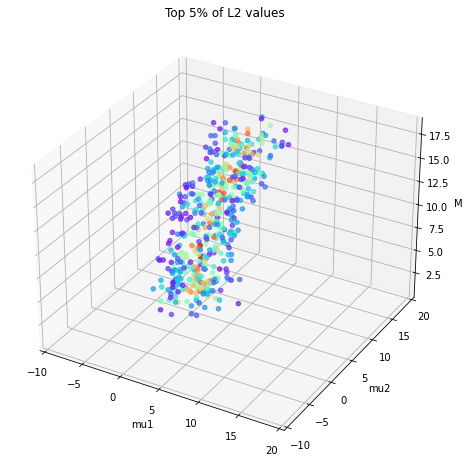

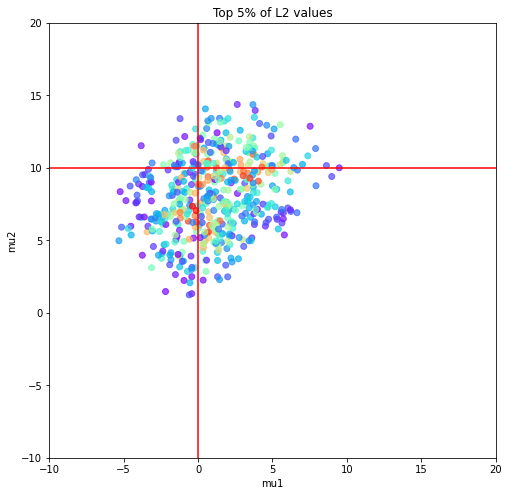

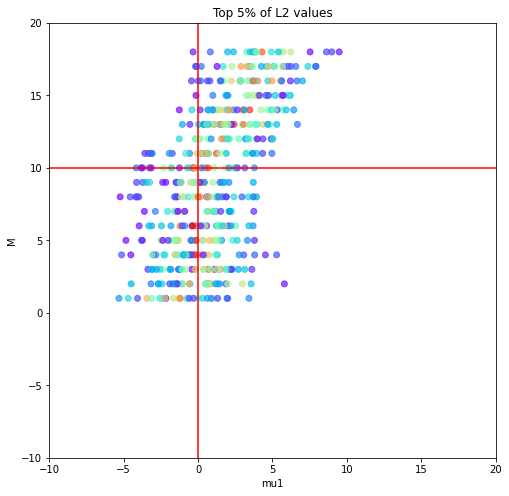

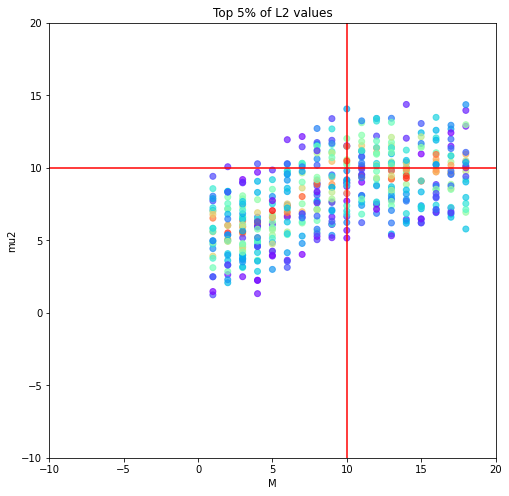

In [76]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Generate some test data
#test = abc(np.append((np.random.normal(0,1,10)),(np.random.normal(10,1,10))),10000,method='L2')
# Find the 95th percentile of the stat values
pct95 = np.percentile(test[3], 95)

# Select the quadruplets with stat in the top 5%
top5 = test[:, test[3] > pct95]

# Create a 3D scatter plot of the mu1, mu2, and M values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(top5[0], top5[1], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
ax.set_zlabel('M')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of L2 values')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.axvline(0, color='red')
ax.axhline(10, color='red')
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
plt.title('Top 5% of L2 values')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.axhline(10, color='red')
ax.axvline(0, color='red')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of L2 values')

ax.set_ylabel('M')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[2], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('M')
ax.set_ylabel('mu2')
ax.axhline(10, color='red')
ax.axvline(10, color='red')
plt.title('Top 5% of L2 values')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

### SR

100%|██████████| 9999/9999 [01:51<00:00, 89.97it/s]
C:\Users\david\AppData\Local\Temp\ipykernel_142232\352379550.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([mu1s,mu2s,Ms,stat])


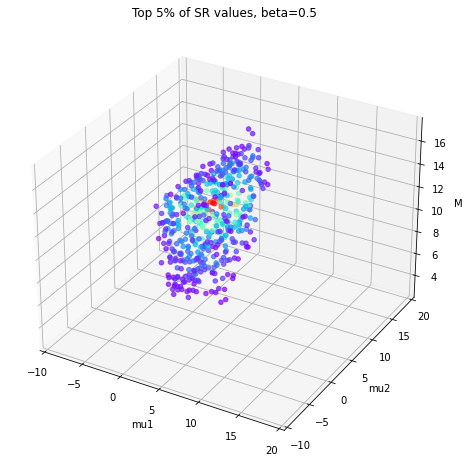

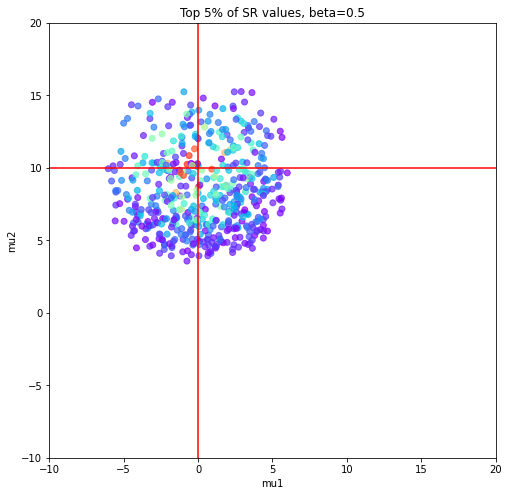

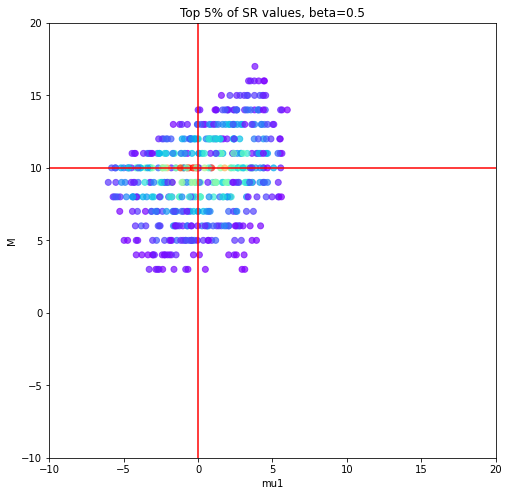

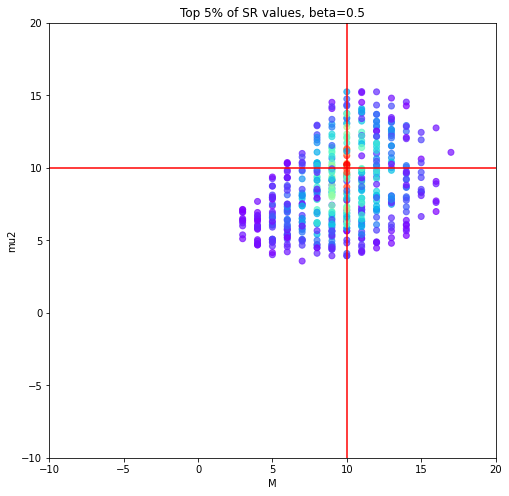

In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Generate some test data
test = abc(np.append((np.random.normal(0,1,10)),(np.random.normal(10,1,10))),10000,method='SR',beta=0.5)
# Find the 95th percentile of the stat values
test[3]=-test[3]
pct95 = np.percentile(test[3], 95)

# Select the quadruplets with stat in the top 5%
top5 = test[:, test[3] > pct95]

# Create a 3D scatter plot of the mu1, mu2, and M values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(top5[0], top5[1], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
ax.set_zlabel('M')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of SR values, beta=0.5')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.axvline(0, color='red')
ax.axhline(10, color='red')
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
plt.title('Top 5% of SR values, beta=0.5')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.axhline(10, color='red')
ax.axvline(0, color='red')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of SR values, beta=0.5')

ax.set_ylabel('M')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[2], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('M')
ax.set_ylabel('mu2')
ax.axhline(10, color='red')
ax.axvline(10, color='red')
plt.title('Top 5% of SR values, beta=0.5')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

  0%|          | 0/9999 [00:00<?, ?it/s]

100%|██████████| 9999/9999 [01:46<00:00, 94.15it/s]
C:\Users\david\AppData\Local\Temp\ipykernel_142232\352379550.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([mu1s,mu2s,Ms,stat])


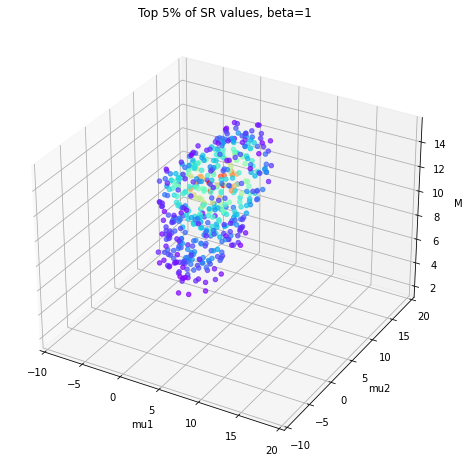

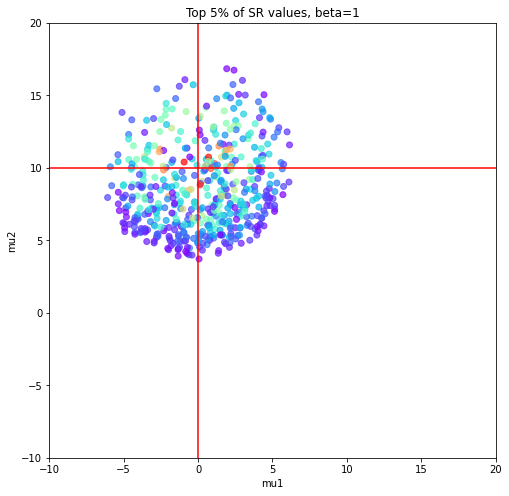

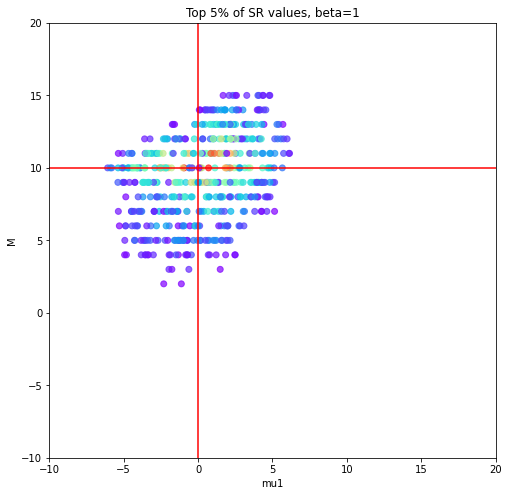

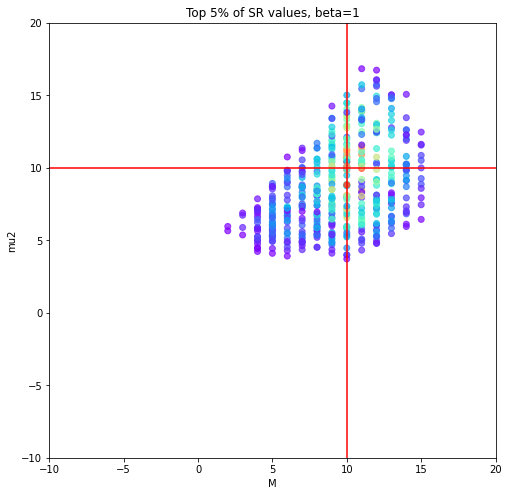

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Generate some test data
test = abc(np.append((np.random.normal(0,1,10)),(np.random.normal(10,1,10))),10000,method='SR',beta=1)
# Find the 95th percentile of the stat values
test[3]=-test[3]

pct95 = np.percentile(test[3], 95)

# Select the quadruplets with stat in the top 5%
top5 = test[:, test[3] > pct95]

# Create a 3D scatter plot of the mu1, mu2, and M values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(top5[0], top5[1], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
ax.set_zlabel('M')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of SR values, beta=1')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.axvline(0, color='red')
ax.axhline(10, color='red')
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
plt.title('Top 5% of SR values, beta=1')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.axhline(10, color='red')
ax.axvline(0, color='red')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of SR values, beta=1')

ax.set_ylabel('M')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[2], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('M')
ax.set_ylabel('mu2')
ax.axhline(10, color='red')
ax.axvline(10, color='red')
plt.title('Top 5% of SR values, beta=1')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

100%|██████████| 9999/9999 [01:46<00:00, 93.65it/s] 
C:\Users\david\AppData\Local\Temp\ipykernel_142232\352379550.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([mu1s,mu2s,Ms,stat])


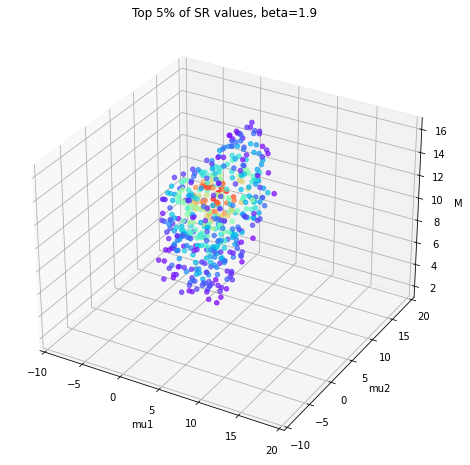

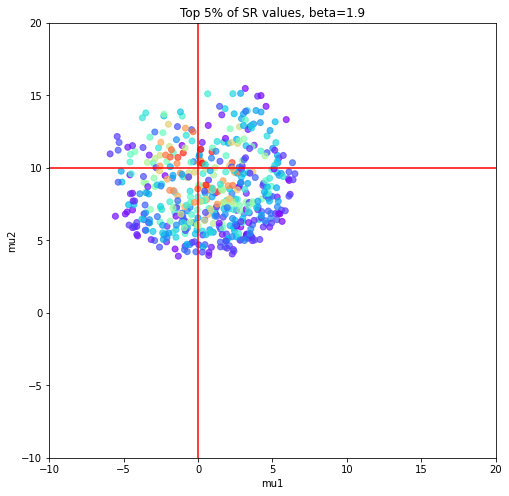

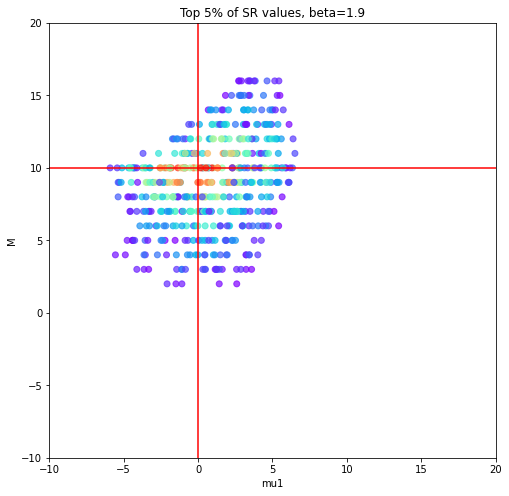

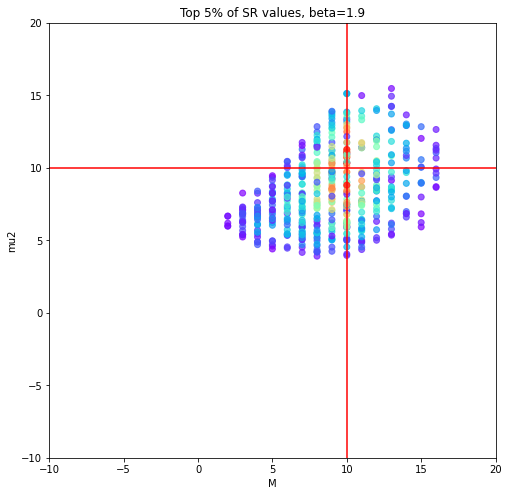

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Generate some test data
test = abc(np.append((np.random.normal(0,1,10)),(np.random.normal(10,1,10))),10000,method='SR',beta=1.9)
# Find the 95th percentile of the stat values
test[3]=-test[3]

pct95 = np.percentile(test[3], 95)

# Select the quadruplets with stat in the top 5%
top5 = test[:, test[3] > pct95]

# Create a 3D scatter plot of the mu1, mu2, and M values
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(top5[0], top5[1], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
ax.set_zlabel('M')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of SR values, beta=1.9')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.axvline(0, color='red')
ax.axhline(10, color='red')
ax.set_xlabel('mu1')
ax.set_ylabel('mu2')
plt.title('Top 5% of SR values, beta=1.9')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[0], top5[2], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('mu1')
ax.axhline(10, color='red')
ax.axvline(0, color='red')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.title('Top 5% of SR values, beta=1.9')

ax.set_ylabel('M')
plt.show()

# Create a scatter plot of the mu1 and mu2 values
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(top5[2], top5[1], c=top5[3], cmap=cm.rainbow, alpha=0.7)
ax.set_xlabel('M')
ax.set_ylabel('mu2')
ax.axhline(10, color='red')
ax.axvline(10, color='red')
plt.title('Top 5% of SR values, beta=1.9')

plt.xlim(-10, 20)
plt.ylim(-10, 20)

plt.show()